<a href="https://colab.research.google.com/github/saurav0530/1901EE54_2021/blob/main/sauravKumar_SCG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
##############################################
#####                                    #####
#####    Name       : Saurav Kumar       #####
#####    Roll       : 1901EE54           ##### 
#####    Supervisor : Dr. Udit Satija    #####
#####                                    #####
##############################################
```



In [ ]:
#################################################
####           DEPENDENCIES-LOADING          ####
#################################################

In [ ]:
# Downloading the project folders from drive to local
# !pip install --upgrade --no-cache-dir gdown
!gdown --id 10mMjqlMIZ95Mr42U82FJsYlUpv5I4zXH
!unzip SCG.zip
!rm SCG.zip

In [ ]:
# Changing the directory
%cd SCG

In [ ]:
# For knowing the current working directory
%pwd

In [ ]:
# Installing all the dependencies
!pip3 install -r requirements.txt

In [ ]:
######################################################
####              PRE-PROCESSING(scg)             ####
######################################################

In [ ]:
# Downloading the dataset from drive to local
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1KmDIw8vLH-b9ud4F25S3sMBt4hv_-YUR
!unzip scg.zip
!rm scg.zip
!mv files scg

In [ ]:
!python pre_processing/index.py

In [ ]:
# Building the segments from each ECG signal
!python pre_processing/make_segments.py

100% 58/58 [00:27<00:00,  2.07it/s]


In [ ]:
# Creating train, test and validation dataset
!python pre_processing/create_datasets.py

In [ ]:
#################################################
####               AUTO-ENCODER              ####
#################################################

In [ ]:
# For training autoencoders
!python autoencoder/train.py settings/config_autoencoder.json

Loading training set...
100% 696/696 [00:03<00:00, 214.18it/s]
Missing data:  0
Loading val set...
100% 174/174 [00:00<00:00, 262.20it/s]
Missing data:  0
Train size: 696 examples.
Val size: 174 examples.
2022-11-28 11:40:57.025647: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
        -- model was built.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10000, 1, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 10000, 1, 8)       48        
                                                                 
 batch_normalization (BatchN  (None, 10000, 1, 8)      32        
 ormalization)                                                   
        

In [ ]:
import os
import shutil
folder = 'saved/autoencoder/'
file = (os.listdir(folder)[1] if os.path.isdir(folder+os.listdir(folder)[1]) else os.listdir(folder)[0])
destt = 'saved/'+file+'_autoencoder'
if not os.path.exists(destt):
    os.makedirs(destt)

for f in os.listdir(folder+file+'/'):
    if f=='0.010-022-0.010.hdf5' or f=='preproc.bin' or f=='train_loss_metric.csv':
        shutil.copyfile(folder+file+'/'+f,destt+'/'+f)
shutil.rmtree(folder)

In [ ]:
# For plotting loss curves
import pandas as pd
import matplotlib.pyplot as plt

temp = pd.read_csv('/content/BTP/saved/1668580417-140_autoencoder/train_loss_metric.csv')
temp = temp.to_numpy()
plt.plot(temp[:, 0], temp[:, 1], color='r', label='train_loss')
plt.plot(temp[:, 0], temp[:, 2], color='g', label='val_loss')

In [ ]:
# Temporary cell commands for deleting a folder if required
import shutil, os
folder = 'saved/autoencoder'
shutil.rmtree(folder)
os.mkdir(folder)

In [ ]:
######################################################
####                   TSNE PLOT                  ####
######################################################

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


28/28 [==============================] - 2s 77ms/step


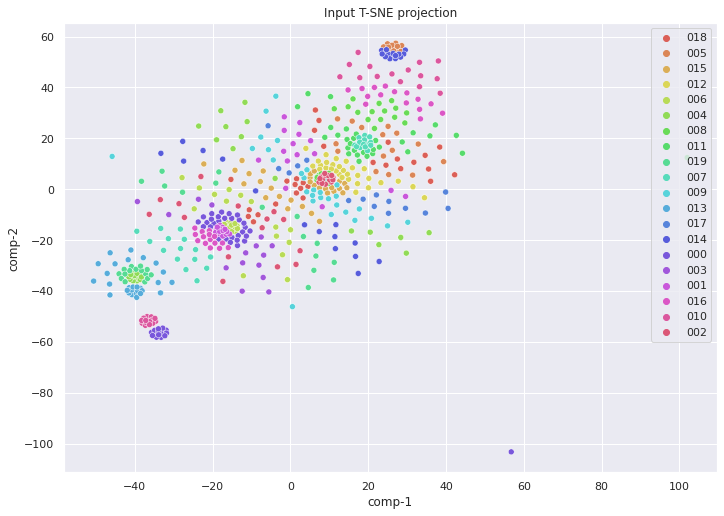

[Text(0.5, 1.0, 'Encoded feature T-SNE projection')]

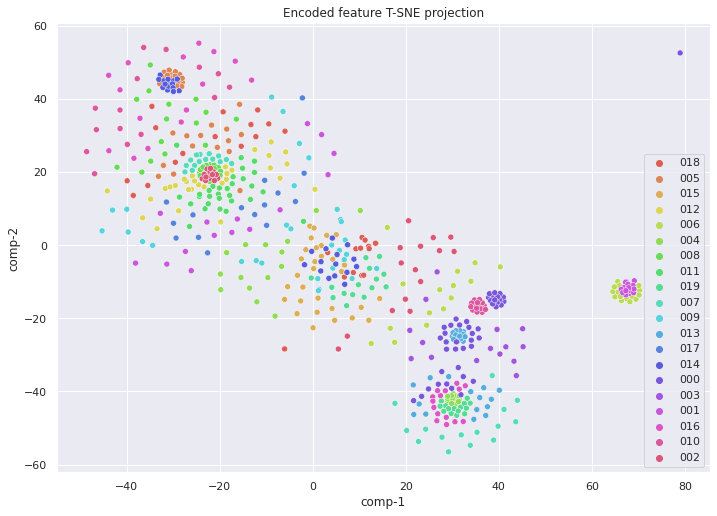

In [ ]:
# For TSNE plot
import pandas as pd
import numpy as np
import os
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

mod_path = '/content/SCG/saved/autoencoder/1669635656-373/0.010-014-0.002.hdf5'

def feature_extraction(model_path, output_layer, signals):
    import tensorflow_addons as tfa
    tfa.losses.TripletSemiHardLoss()

    dependencies = {'loss': tfa.losses.TripletSemiHardLoss()}
    model = tf.keras.models.load_model(model_path, custom_objects=dependencies)
    if not output_layer == "sequential":
        out = model.get_layer(output_layer).output
        model = tf.keras.Model(model.input, out)

    data_preproc = np.array([e for e in signals]).astype(np.float)
    features = model.predict(data_preproc)
    return features

def load_signal(record):
    signal = pd.read_csv(record, header=None)
    signal = signal.to_numpy()

    signal1 = np.asarray(signal)
    signal1 = signal1.reshape(10000)
    
    signal = np.expand_dims(signal, axis=-1)  # Create feature dimension
    return signal, signal1


sig = []
inp = []
tar = []
file_path = 'datasets/scg'
for i in os.listdir(file_path):
  if i == 'preproc_csv' or i == 'start_points.json':
    continue

  
  for j in os.listdir(file_path+'/'+i):
    for k in os.listdir(file_path+'/'+i+'/'+j):
      a, b = load_signal(file_path+'/'+i+'/'+j+'/'+k)
      sig.append(a)
      inp.append(b)
      tar.append(i)

X = feature_extraction(mod_path, 'flatten', sig)
# print(len(X), X[0].shape)
# print(len(tar))

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=0, random_state= 0)


z = tsne.fit_transform(inp)
df = pd.DataFrame()
df["y"] = tar
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 20),
                data=df).set(title="Input T-SNE projection")

plt.show()

from sklearn.manifold import TSNE
import seaborn as sns
tsne1 = TSNE(n_components=2, verbose=0, random_state= 0)
z1 = tsne1.fit_transform(X)
df1 = pd.DataFrame()
df1["y"] = tar
df1["comp-1"] = z1[:,0]
df1["comp-2"] = z1[:,1]

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x="comp-1", y="comp-2", hue=df1.y.tolist(),
                palette=sns.color_palette("hls", 20),
                data=df1).set(title="Encoded feature T-SNE projection")


# print(load_signal('datasets/scg/000/001/000.csv'))


In [ ]:
#################################################
####               VERIFICATION              ####
#################################################

In [ ]:
# For training Siamese network
!python verification/train.py

Loading training set...
100% 580/580 [00:02<00:00, 271.52it/s]
Missing data:  0
2022-11-28 11:45:13.963180: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
19/19 [==============================] - 4s 88ms/step
Loading val set...
100% 58/58 [00:00<00:00, 291.22it/s]
Missing data:  0
2/2 [==============================] - 1s 583ms/step
Train size: 580 examples.
Val size: 58 examples.
        -- model was built.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1250, 2, 1)  0           []                               
                                ]                                                                 
                                  

In [ ]:
import os
import shutil
folder = 'saved/verification/'
file = (os.listdir(folder)[1] if os.path.isdir(folder+os.listdir(folder)[1]) else os.listdir(folder)[0])
destt = 'saved/'+file+'_verification'
if not os.path.exists(destt):
    os.makedirs(destt)

for f in os.listdir(folder+file+'/'):
    if f=='0.115-0.949-077-0.081-0.965.hdf5' or f=='preproc.bin' or f=='train_loss_metric.csv':
        shutil.copyfile(folder+file+'/'+f,destt+'/'+f)
shutil.rmtree(folder)

In [ ]:
# For plotting loss curves
import pandas as pd
import matplotlib.pyplot as plt

temp = pd.read_csv('/content/BTP/saved/1668593916-226_verification/train_loss_metric.csv')
temp = temp.to_numpy()
plt.title("Verification")
plt.plot(temp[:, 0], temp[:, 1], color='r', label='train_loss')
plt.plot(temp[:, 0], temp[:, 2], color='g', label='val_loss')
plt.title("Verification")
plt.legend()
plt.show()

In [ ]:
!python verification/predict.py --model_path "/content/SCG/saved/1669635921-792_verification/0.115-0.949-077-0.081-0.965.hdf5"

Loading testing set...
100% 232/232 [00:01<00:00, 169.84it/s]
Missing data:  0
2022-11-28 12:08:31.282991: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
8/8 [==============================] - 4s 108ms/step
Test size: 232 examples.
100% 20/20 [00:00<00:00, 68.93it/s]
11500
230/230 [==============================] - 2s 10ms/step
AUC:  0.9889153157894737
Confusion Matrix: 
 [[9177  323]
 [ 198 1802]]
Accuracy:  0.9546956521739131
Negative samples:  9500
Positive samples:  2000
EER:  0.04743421052631579  - Threshold:  0.36389464
EERS:  [0.04743421052631579]
count    1.000000
mean     0.047434
std           NaN
min      0.047434
25%      0.047434
50%      0.047434
75%      0.047434
max      0.047434
dtype: float64
4.74%


In [ ]:
#################################################
####              IDENTIFICATION             ####
#################################################

In [ ]:
# For training Siamese identification network
!python identification/train.py settings/config_identification.json

Loading training set...
100% 580/580 [00:02<00:00, 268.24it/s]
Missing data:  0
2022-11-28 12:11:04.358330: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
19/19 [==============================] - 4s 85ms/step
Loading val set...
100% 58/58 [00:00<00:00, 301.58it/s]
Missing data:  0
2/2 [==============================] - 1s 621ms/step
Train size: 580 examples.
Val size: 58 examples.
        -- model was built.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1250, 2, 1)  0           []                               
                                ]                                                                 
                                  

In [ ]:
# 1641449739-387_1L-Siamese 0.461-0.836-019-0.349-0.856.hdf5
import os
import shutil
folder = 'saved/identification/'
file = (os.listdir(folder)[1] if os.path.isdir(folder+os.listdir(folder)[1]) else os.listdir(folder)[0])
destt = 'saved/'+file+'_identification'
if not os.path.exists(destt):
    os.makedirs(destt)

for f in os.listdir(folder+file+'/'):
    if f=='0.071-0.969-019-0.057-0.987.hdf5' or f=='preproc.bin' or f=='train_loss_metric.csv':
        shutil.copyfile(folder+file+'/'+f,destt+'/'+f)
shutil.rmtree(folder)

In [ ]:
# For plotting loss curves
import pandas as pd
import matplotlib.pyplot as plt

temp = pd.read_csv('/content/BTP/saved/identification/1668594439-870/train_loss_metric.csv')
temp = temp.to_numpy()

plt.plot(temp[:, 0], temp[:, 1], color='r', label='train_loss')
plt.plot(temp[:, 0], temp[:, 2], color='g', label='val_loss')
plt.title("Identification")
plt.legend()
plt.show()

In [ ]:
!python identification/predict.py --model_path "/content/SCG/saved/identification/1669637472-777/0.058-0.969-021-0.091-0.962.hdf5"

Loading testing set...
100% 232/232 [00:00<00:00, 261.32it/s]
Missing data:  0
2022-11-28 12:20:24.593942: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
8/8 [==============================] - 4s 101ms/step
Test size: 232 examples.
5/5 [==============================] - 0s 3ms/step
Confusion Matrix: 
 [[8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 

In [ ]:
# Temporary cell commands for deleting a folder if required
import shutil, os
folder = 'SCG'
shutil.rmtree(folder)

In [ ]:
#################################################
####             SAVING TO GDRIVE            ####
#################################################

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd SCG
%pwd

In [ ]:
# Updating the changed folder to drive
%cd ..
!zip -r SCG.zip SCG
%cp SCG.zip drive/MyDrive/Saurav/SCG.zip
!rm SCG.zip